In [2]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

# The data is stored as a NumPy array
X, y = mnist["data"], mnist["target"]



In [4]:
def one_hot_encode(y, num_classes):
    return np.eye(num_classes)[y]

In [5]:
def load_batch(X,y,batch_size=64):
    n = X.shape[0]

    for i in range(0,n,batch_size):
        begin,end = i, min(i + batch_size,n)

        if y is not None:
            yield X[begin:end],y[begin:end]

        else:
            yield X[begin:end]
    

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [7]:
X_train,X_test = X_train/255.0,X_test/255.0
X_test.shape

(14000, 784)

In [8]:
def to_categorical(x, n_col=None):
    if not n_col:
        n_col = np.max(x) + 1
        one_hot = np.zeros ((x.shape[0], n_col))
        one_hot [np. arange (x.shape[0]), x] = 1
        return one_hot

In [9]:
y_train = to_categorical(y_train.astype("int"))

In [10]:
y_test = to_categorical(y_test.astype("int"))

In [11]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], shape=(56000, 10))

In [12]:
class CrossEntropy():
  def __init__(self): pass

  def loss(self, y, p):
    p = np.clip(p, 1e-15, 1- 1e-15)
    return -y*np.log(p) - (1 - y) * np.log(1- p)
  
  def gradient(self, y, p):
    p = np.clip(p, 1e-15, 1- 1e-15)
    return -(y/p) + (1 - y) / (1 - p)

In [13]:
class LeakyRELU():
    def __init__(self,alpha=0.2):
        self.alpha = alpha

    def __call__(self,x):
        return self.forward(x)

    def forward(self,x):
        return np.where(x>=0,x,self.alpha*x)
    
    def backward(self,x):
        return np.where(x>=0,1,self.alpha)

In [14]:
class CrossEntropy:
    def __init__(self):
        pass

    def loss(self, y_true, y_pred):
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return -np.sum(y_true * np.log(y_pred), axis=-1)

    def gradient(self, y_true, y_pred):
        return y_pred - y_true

In [15]:
class Softmax:
    def __init__(self):
        pass

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

    def backward(self, x):
        s = self.forward(x)
        return s * (1 - s)

In [16]:
class Activation():
    def __init__(self,activation,name="activation"):
        self.activation = activation
        self.gradient = activation.backward
        self.input = None
        self.output = None

    def forward(self,x):
        self.input = x 
        self.output = self.activation(x)
        return self.output
    
    def backward(self,grad_flow):
        return self.gradient(self.input)*grad_flow
    
    def __call__(self, x):
        return self.forward(x)


In [37]:
class Dropout:
    def __init__(self,dropout_rate):
        self.dropout_rate = dropout_rate
        self.training = True
        self.mask = None

    def __call__(self, x):
        if(self.training):
            self.mask = (np.random.rand(*x.shape) > self.dropout_rate).astype(np.float32)
            return x * self.mask / ( 1.0 - self.dropout_rate)
        else:
            return x
        
    def backward(self,grad_output):
        if self.training:
            return grad_output * self.mask / (1.0 - self.dropout_rate)
        else:
            return grad_output

In [38]:
class Layer():

    def __init__(self, n_in, n_out, name="linear"):
        n = 1 / np.sqrt(n_in)
        # init weights
        self.weights = np.random.uniform(-n, n, size=(n_in, n_out))
        self.bias = np.zeros((1, n_out))
        self.input = None
        self.output = None

    def forward(self, x):
        self.input = x
        output = np.dot(x, self.weights) + self.bias
        self.output = output
        return output

    def backward(self, grad_flow, learning_rate=0.01):
        # grad_flow: (batch_size, n_out)
        input_error = np.dot(grad_flow, self.weights.T)  # (batch_size, n_in)
        delta_W = np.dot(self.input.T, grad_flow)        # (n_in, n_out)

        self.weights -= learning_rate * delta_W
        self.bias -= learning_rate * np.mean(grad_flow, axis=0, keepdims=True)

        return input_error

    def __call__(self, x):
        return self.forward(x)


In [45]:
class MLP():
    def __init__(self,input_dim,output_dim,dropout_rate):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layers = [
            Layer(input_dim,256,"input"),
            Activation(LeakyRELU(),name="input"),
            Dropout(dropout_rate=dropout_rate),

            Layer(256,128,name="input"),
            Activation(LeakyRELU(),name="input"),
            Dropout(dropout_rate=dropout_rate),

            Layer(128,64,name="input"),
            Activation(LeakyRELU(),name="input"),
            Dropout(dropout_rate=dropout_rate),
            
            Layer(64,10,name="input"),
            Activation(Softmax(),name="output")
        ]

        self.lr = 0.01

    def forward(self,x):
        for layer in self.layers:
            x = layer(x)

        return x
    
    def backward(self,grad_flow):
        for layer in reversed(self.layers):
            grad_flow = layer.backward(grad_flow)

    def train(self, mode=True):
        for layer in self.layers:
            if hasattr(layer, 'training'):
                layer.training = mode

    def __call__(self, x):
        return self.forward(x)

In [46]:
model = MLP(784,10,dropout_rate = 0.1)
criterian = CrossEntropy()

model.train(mode=True)

In [41]:
def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))

In [49]:
for epoch in range(10):
  loss = []
  acc = []
  for x_batch, y_batch in load_batch(X_train, y_train):
    out = model(x_batch) # Forward pass
    loss.append(np.mean(criterian.loss(y_batch, out))) # Loss - for display
    # We just passed the inputs incorrectly.
    acc.append(accuracy(y_batch, out))
    error = criterian.gradient(y_batch, out) # Calculate gradient of loss
    model.backward(error) # Backpropagation
  
  print(f"Epoch {epoch + 1}, Loss: {np.mean(loss)}, Acc: {np.mean(acc)}")

Epoch 1, Loss: 0.04764431857474081, Acc: 0.9872678571428571
Epoch 2, Loss: 0.04585108347296649, Acc: 0.988
Epoch 3, Loss: 0.04354989461555127, Acc: 0.9889642857142857
Epoch 4, Loss: 0.043605834290940754, Acc: 0.9882678571428571
Epoch 5, Loss: 0.04136724332056346, Acc: 0.9893035714285714
Epoch 6, Loss: 0.040310807511487044, Acc: 0.9894821428571429
Epoch 7, Loss: 0.042287231157435747, Acc: 0.9891964285714285
Epoch 8, Loss: 0.039254560627530674, Acc: 0.9895178571428571
Epoch 9, Loss: 0.0398987827088587, Acc: 0.9898928571428571
Epoch 10, Loss: 0.03681191937504354, Acc: 0.9906607142857143


X_test shape: (14000, 784)


Epoch 1, Loss: 0.7800219681735377, Acc: 0.7562857142857143
Epoch 2, Loss: 0.2210455708121314, Acc: 0.9383571428571429
Epoch 3, Loss: 0.15388059018723596, Acc: 0.9574464285714286
Epoch 4, Loss: 0.1229797052552209, Acc: 0.9670357142857143
Epoch 5, Loss: 0.10356814135585371, Acc: 0.9733571428571428
Epoch 6, Loss: 0.08878785984205777, Acc: 0.9775714285714285
Epoch 7, Loss: 0.07727036740633787, Acc: 0.9810892857142857
Epoch 8, Loss: 0.06851667633956798, Acc: 0.983625
Epoch 9, Loss: 0.061969628189894384, Acc: 0.985875
Epoch 10, Loss: 0.05699097083491795, Acc: 0.9869285714285714


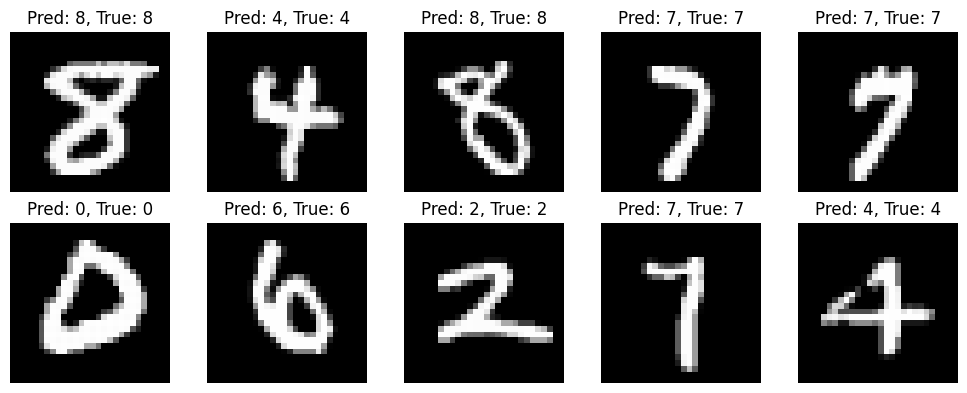

In [50]:
#plot predictions
def plot_predictions(X, y, model, num_images=10):
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title(f"Pred: {np.argmax(model(X[i:i+1]))}, True: {np.argmax(y[i])}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
plot_predictions(X_test, y_test, model, num_images=10)

In [51]:
test_accuracy = accuracy(y_test,model(X_test))

In [52]:
test_accuracy

np.float64(0.9721428571428572)

In [58]:
y = np.arange(len(loss))


In [59]:
y

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [65]:
y = reversed(y)

TypeError: 'reversed' object is not reversible